In [1]:
%matplotlib inline

In [2]:
#!pip install nni
#!pip install pytorch-lightning


# Searching in DARTS search space

In this tutorial, we demonstrate how to search in the famous model space proposed in `DARTS`.

Through this process, you will learn:

* How to use the built-in model spaces from NNI's model space hub.
* How to use one-shot exploration strategies to explore a model space.
* How to customize evaluators to achieve the best performance.

In the end, we get a strong-performing model on CIFAR-10 dataset, which achieves up to 97.28% accuracy.

.. attention::

   Running this tutorial requires a GPU.
   If you don't have one, you can set ``gpus`` in :class:`~nni.nas.evaluator.pytorch.Classification` to be 0,
   but do note that it will be much slower.


## Use a pre-searched DARTS model

Similar to [the beginner tutorial of PyTorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)_,
we begin with CIFAR-10 dataset, which is a image classification dataset of 10 categories.
The images in CIFAR-10 are of size 3x32x32, i.e., RGB-colored images of 32x32 pixels in size.

We first load the CIFAR-10 dataset with torchvision.


In [4]:
import nni
import torch
from torchvision import transforms
from torchvision.datasets import CIFAR10
from nni.nas.evaluator.pytorch import DataLoader

CIFAR_MEAN = [0.49139968, 0.48215827, 0.44653124]
CIFAR_STD = [0.24703233, 0.24348505, 0.26158768]

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
])
valid_data = nni.trace(CIFAR10)(root='./data', train=False, download=True, transform=transform_valid)
valid_loader = DataLoader(valid_data, batch_size=256, num_workers=6)

<div class="alert alert-info"><h4>Note</h4><p>If you are to use multi-trial strategies, wrapping CIFAR10 with :func:`nni.trace` and
   use DataLoader from ``nni.nas.evaluator.pytorch`` (instead of ``torch.utils.data``) are mandatory.
   Otherwise, it's optional.</p></div>

NNI presents many built-in model spaces, along with many *pre-searched models* in :doc:`model space hub </nas/space_hub>`,
which are produced by most popular NAS literatures.
A pre-trained model is a saved network that was previously trained on a large dataset like CIFAR-10 or ImageNet.
You can easily load these models as a starting point, validate their performances, and finetune them if you need.

In this tutorial, we choose one from `DARTS`_ search space, which is natively trained on our target dataset, CIFAR-10,
so as to save the tedious steps of finetuning.

.. tip::

   Finetuning a pre-searched model on other datasets is no different from finetuning *any model*.
   We recommend reading
   [this tutorial of object detection finetuning](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)_
   if you want to know how finetuning is generally done in PyTorch.



## Use the DARTS model space

The model space provided in `DARTS`_ originated from [NASNet](https://arxiv.org/abs/1707.07012)_,
where the full model is constructed by repeatedly stacking a single computational unit (called a **cell**).
There are two types of cells within a network. The first type is called *normal cell*, and the second type is called *reduction cell*.
The key difference between normal and reduction cell is that the reduction cell will downsample the input feature map,
and decrease its resolution. Normal and reduction cells are stacked alternately, as shown in the following figure.

<img src="https://nni.readthedocs.io/en/stable/_images/nasnet_cell_stack.png">

A cell takes outputs from two previous cells as inputs and contains a collection of *nodes*.
Each node takes two previous nodes within the same cell (or the two cell inputs),
and applies an *operator* (e.g., convolution, or max-pooling) to each input,
and sums the outputs of operators as the output of the node.
The output of cell is the concatenation of all the nodes that are never used as inputs of another node.
Users could read [NDS](https://arxiv.org/pdf/1905.13214.pdf)_ or [ENAS](https://arxiv.org/abs/1802.03268)_ for more details.

We illustrate an example of cells in the following figure.

<img src="https://nni.readthedocs.io/en/stable/_images/nasnet_cell.png">

The search space proposed in `DARTS`_ paper introduced two modifications to the original space
in [NASNet](https://arxiv.org/abs/1707.07012)_.

Firstly, the operator candidates have been narrowed down to seven:

- Max pooling 3x3
- Average pooling 3x3
- Skip connect (Identity)
- Separable convolution 3x3
- Separable convolution 5x5
- Dilated convolution 3x3
- Dilated convolution 5x5

Secondly, the output of cell is the concatenate of **all the nodes within the cell**.

As the search space is based on cell, once the normal and reduction cell has been fixed, we can stack them for indefinite times.
To save the search cost, the common practice is to reduce the number of filters (i.e., channels) and number of stacked cells
during the search phase, and increase them back when training the final searched architecture.

<div class="alert alert-info"><h4>Note</h4><p>`DARTS`_ is one of those papers that innovate both in search space and search strategy.
   In this tutorial, we will search on **model space** provided by DARTS with **search strategy** proposed by DARTS.
   We refer to them as *DARTS model space* (``DartsSpace``) and *DARTS strategy* (``DartsStrategy``), respectively.
   We did NOT imply that the :class:`~nni.nas.hub.pytorch.DARTS` space and
   :class:`~nni.nas.strategy.DARTS` strategy has to used together.
   You can always explore the DARTS space with another search strategy, or use your own strategy to search a different model space.</p></div>

In the following example, we initialize a :class:`~nni.nas.hub.pytorch.DARTS`
model space, with 16 initial filters and 8 stacked cells.
The network is specialized for CIFAR-10 dataset with 32x32 input resolution.

The :class:`~nni.nas.hub.pytorch.DARTS` model space here is provided by :doc:`model space hub </nas/space_hub>`,
where we have supported multiple popular model spaces for plug-and-play.

.. tip::

   The model space here can be replaced with any space provided in the hub,
   or even customized spaces built from scratch.



In [5]:
from nni.nas.hub.pytorch import DARTS as DartsSpace

model_space = DartsSpace(
    width=16,           # the initial filters (channel number) for the model
    num_cells=8,        # the number of stacked cells in total
    dataset='cifar'     # to give a hint about input resolution, here is 32x32
)

/home/anaconda/lib/python3.9/site-packages/nni/nas/nn/pytorch/layers.py:94: RuntimeWarning: <class 'torch.nn.parameter.Buffer'> is found to be not a nn.Module, which is unexpected. It means your PyTorch version might not be supported.
  warnings.warn(f'{obj} is found to be not a nn.Module, which is unexpected. '


## Search on the model space

<div class="alert alert-danger"><h4>Warning</h4><p>Please set ``fast_dev_run`` to False to reproduce the our claimed results.
   Otherwise, only a few mini-batches will be run.</p></div>



In [6]:
fast_dev_run = True

### Evaluator

To begin exploring the model space, one firstly need to have an evaluator to provide the criterion of a "good model".
As we are searching on CIFAR-10 dataset, one can easily use the :class:`~nni.nas.evaluator.pytorch.Classification`
as a starting point.

Note that for a typical setup of NAS, the model search should be on validation set, and the evaluation of the final searched model
should be on test set. However, as CIFAR-10 dataset doesn't have a test dataset (only 50k train + 10k valid),
we have to split the original training set into a training set and a validation set.
The recommended train/val split by `DARTS`_ strategy is 1:1.



In [7]:
import numpy as np
from nni.nas.evaluator.pytorch import Classification
from torch.utils.data import SubsetRandomSampler

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
])

train_data = nni.trace(CIFAR10)(root='./data', train=True, download=True, transform=transform)

num_samples = len(train_data)
indices = np.random.permutation(num_samples)
split = num_samples // 2

search_train_loader = DataLoader(
    train_data, batch_size=64, num_workers=6,
    sampler=SubsetRandomSampler(indices[:split]),
)

search_valid_loader = DataLoader(
    train_data, batch_size=64, num_workers=6,
    sampler=SubsetRandomSampler(indices[split:]),
)

evaluator = Classification(
    learning_rate=1e-3,
    weight_decay=1e-4,
    train_dataloaders=search_train_loader,
    val_dataloaders=search_valid_loader,
    max_epochs=10,
    accelerator='auto',
    fast_dev_run=fast_dev_run,
    num_classes = 10
)

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


### Strategy

We will use `DARTS`_ (Differentiable ARchiTecture Search) as the search strategy to explore the model space.
:class:`~nni.nas.strategy.DARTS` strategy belongs to the category of `one-shot strategy <one-shot-nas>`.
The fundamental differences between One-shot strategies and `multi-trial strategies <multi-trial-nas>` is that,
one-shot strategy combines search with model training into a single run.
Compared to multi-trial strategies, one-shot NAS doesn't need to iteratively spawn new trials (i.e., models),
and thus saves the excessive cost of model training.

<div class="alert alert-info"><h4>Note</h4><p>It's worth mentioning that one-shot NAS also suffers from multiple drawbacks despite its computational efficiency.
   We recommend
   [Weight-Sharing Neural Architecture Search: A Battle to Shrink the Optimization Gap](https://arxiv.org/abs/2008.01475)_
   and
   [How Does Supernet Help in Neural Architecture Search?](https://arxiv.org/abs/2010.08219)_ for interested readers.</p></div>

:class:`~nni.nas.strategy.DARTS` strategy is provided as one of NNI's :doc:`built-in search strategies </nas/exploration_strategy>`.
Using it can be as simple as one line of code.



In [8]:
from nni.nas.strategy import DARTS as DartsStrategy

strategy = DartsStrategy()

.. tip:: The ``DartsStrategy`` here can be replaced by any search strategies, even multi-trial strategies.

If you want to know how DARTS strategy works, here is a brief version.
Under the hood, DARTS converts the cell into a densely connected graph, and put operators on edges (see the following figure).
Since the operators are not decided yet, every edge is a weighted mixture of multiple operators (multiple color in the figure).
DARTS then learns to assign the optimal "color" for each edge during the network training.
It finally selects one "color" for each edge, and drops redundant edges.
The weights on the edges are called *architecture weights*.

<img src="https://nni.readthedocs.io/en/stable/_images/darts_illustration.png">

.. tip:: It's NOT reflected in the figure that, for DARTS model space, exactly two inputs are kept for every node.

### Launch experiment

We then come to the step of launching the experiment.
This step is similar to what we have done in the :doc:`beginner tutorial <hello_nas>`.



In [9]:
from nni.nas.experiment import NasExperiment

experiment = NasExperiment(model_space, evaluator, strategy)
experiment.run()

[2026-02-23 19:30:18] Config is not provided. Will try to infer.
[2026-02-23 19:30:18] Strategy is found to be a one-shot strategy. Setting execution engine to "sequential" and format to "raw".
[2026-02-23 19:30:18] WARNING: `training_service` will be ignored for sequential execution engine.
[2026-02-23 19:30:18] WARNING: `training_service` will be ignored for sequential execution engine.
[2026-02-23 19:30:18] WARNING: `training_service` will be ignored for sequential execution engine.
[2026-02-23 19:30:22] WARNING: `training_service` will be ignored for sequential execution engine.
[2026-02-23 19:30:22] WARNING: `training_service` will be ignored for sequential execution engine.
[2026-02-23 19:30:22] WARNING: `training_service` will be ignored for sequential execution engine.
[2026-02-23 19:30:22] WARNING: `training_service` will be ignored for sequential execution engine.
[2026-02-23 19:30:22] WARNING: `training_service` will be ignored for sequential execution engine.
[2026-02-23 19

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name            | Type                 | Params | Mode  | FLOPs
-------------------------------------------------------------------------
0 | training_module | ClassificationModule | 2.0 M  | train | 0    
-------------------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.950     Total estimated model params size (MB)
8031      Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_steps=1` reached.


[2026-02-23 19:30:29] Waiting for models submitted to engine to finish...
[2026-02-23 19:30:29] Experiment is completed.
[2026-02-23 19:30:29] WARNING: `training_service` will be ignored for sequential execution engine.


True

.. tip::

   The search process can be visualized with tensorboard. For example::

       tensorboard --logdir=./lightning_logs

   Then, open the browser and go to http://localhost:6006/ to monitor the search process.

   .. image:: ../../img/darts_search_process.png

We can then retrieve the best model found by the strategy with ``export_top_models``.
Here, the retrieved model is a dict (called *architecture dict*) describing the selected normal cell and reduction cell.



In [10]:
exported_arch = experiment.export_top_models(formatter='dict')[0]

exported_arch

[2026-02-23 19:30:57] Sorted weights in differentiable cell export (normal cell, node 2): [(0.0014604538446292281, 1, 'skip_connect'), (0.0010268462356179953, 0, 'skip_connect'), (0.0012451536022126675, 1, 'sep_conv_3x3'), (0.0008088999311439693, 0, 'dil_conv_5x5'), (0.0007595428032800555, 1, 'sep_conv_5x5'), (0.000347840046742931, 1, 'max_pool_3x3'), (0.00027115270495414734, 1, 'avg_pool_3x3'), (0.00013681716518476605, 0, 'max_pool_3x3'), (-1.4729826034454163e-05, 1, 'dil_conv_3x3'), (-0.00013216090155765414, 0, 'dil_conv_3x3'), (-0.00021052559895906597, 1, 'dil_conv_5x5'), (-0.00039163086330518126, 0, 'sep_conv_3x3'), (-0.0015287476126104593, 0, 'sep_conv_5x5'), (-0.0017672309186309576, 0, 'avg_pool_3x3')]
[2026-02-23 19:30:57] Sorted weights in differentiable cell export (normal cell, node 3): [(0.001624904340133071, 0, 'sep_conv_5x5'), (0.0012769245076924562, 2, 'dil_conv_5x5'), (0.001202505431137979, 1, 'avg_pool_3x3'), (0.0012438648846000433, 2, 'dil_conv_3x3'), (0.00108050880953

{'normal/op_2_0': 'skip_connect',
 'normal/input_2_0': [1],
 'normal/op_2_1': 'skip_connect',
 'normal/input_2_1': [0],
 'normal/op_3_0': 'sep_conv_5x5',
 'normal/input_3_0': [0],
 'normal/op_3_1': 'dil_conv_5x5',
 'normal/input_3_1': [2],
 'normal/op_4_0': 'dil_conv_5x5',
 'normal/input_4_0': [1],
 'normal/op_4_1': 'max_pool_3x3',
 'normal/input_4_1': [3],
 'normal/op_5_0': 'max_pool_3x3',
 'normal/input_5_0': [3],
 'normal/op_5_1': 'skip_connect',
 'normal/input_5_1': [4],
 'reduce/op_2_0': 'sep_conv_3x3',
 'reduce/input_2_0': [1],
 'reduce/op_2_1': 'avg_pool_3x3',
 'reduce/input_2_1': [0],
 'reduce/op_3_0': 'max_pool_3x3',
 'reduce/input_3_0': [2],
 'reduce/op_3_1': 'max_pool_3x3',
 'reduce/input_3_1': [1],
 'reduce/op_4_0': 'dil_conv_3x3',
 'reduce/input_4_0': [0],
 'reduce/op_4_1': 'sep_conv_5x5',
 'reduce/input_4_1': [3],
 'reduce/op_5_0': 'avg_pool_3x3',
 'reduce/input_5_0': [4],
 'reduce/op_5_1': 'sep_conv_5x5',
 'reduce/input_5_1': [1]}

The cell can be visualized with the following code snippet
(copied and modified from [DARTS visualization](https://github.com/quark0/darts/blob/master/cnn/visualize.py)_).



<div class="alert alert-danger"><h4>Warning</h4><p>The cell above is obtained via ``fast_dev_run`` (i.e., running only 1 mini-batch).</p></div>

When ``fast_dev_run`` is turned off, we get a model with the following architecture,
where you might notice an interesting fact that around half the operations have selected ``sep_conv_3x3``.



In [14]:
#!apt-get update

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [128 kB]
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease                         
Get:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease [128 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [4432 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [4801 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Get:7 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [33.1 kB]
Get:8 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1308 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [128 kB]      
Get:10 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1599 kB]
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [2785 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal-u

In [15]:
!apt-get install graphviz -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fontconfig fontconfig-config fonts-dejavu-core fonts-liberation libann0
  libcairo2 libcdt5 libcgraph6 libdatrie1 libfontconfig1 libfreetype6
  libfribidi0 libgd3 libglib2.0-0 libglib2.0-data libgraphite2-3 libgts-0.7-5
  libgts-bin libgvc6 libgvpr2 libharfbuzz0b libice6 libjbig0 libjpeg-turbo8
  libjpeg8 liblab-gamut1 libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0
  libpathplan4 libpixman-1-0 libpng16-16 libsm6 libthai-data libthai0 libtiff5
  libwebp6 libxaw7 libxcb-render0 libxcb-shm0 libxmu6 libxpm4 libxrender1
  libxt6 shared-mime-info ucf x11-common xdg-user-dirs
Suggested packages:
  gsfonts graphviz-doc libgd-tools
The following NEW packages will be installed:
  fontconfig fontconfig-config fonts-dejavu-core fonts-liberation graphviz
  libann0 libcairo2 libcdt5 libcgraph6 libdatrie1 libfontconfig1 libfreetype6
  libfribidi0

Selecting previously unselected package fonts-liberation.
Preparing to unpack .../09-fonts-liberation_1%3a1.07.4-11_all.deb ...
Unpacking fonts-liberation (1:1.07.4-11) ...
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
Selecting previously unselected package libfontconfig1:amd64.
Preparing to unpack .../11-libfontconfig1_2.13.1-2ubuntu3_amd64.deb ...
Unpacking libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Selecting previously unselected package fontconfig.
Preparing to unpack .../12-fontconfig_2.13.1-2ubuntu3_amd64.deb ...
Unpacking fontconfig (2.13.1-2ubuntu3) ...
Selecting previously unselected package libann0.
Preparing to unpack .../13-libann0_1.1.2+doc-7build1_amd64.deb ...
Unpacking libann0 (1.1.2+doc-7build1) ...
Selecting previously unselected package libcdt5:amd64.
Preparing to unpack .../14-libcdt5_2.42.2-3build2_amd64.deb ...
Unpacking libcdt5:

Setting up libann0 (1.1.2+doc-7build1) ...
Setting up libfribidi0:amd64 (1.0.8-2ubuntu0.1) ...
Setting up shared-mime-info (1.15-1) ...
Setting up libpng16-16:amd64 (1.6.37-2) ...
Setting up libwebp6:amd64 (0.6.1-2ubuntu0.20.04.3) ...
Setting up fonts-dejavu-core (2.37-1) ...
Setting up ucf (3.0038+nmu1) ...
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76.)
debconf: falling back to frontend: Readline
Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Setting up fonts-liberation (1:1.07.4-11) ...
Setting up libthai-data (0.1.28-3) ...
Setting up libcdt5:amd64 (2.42.2-3build2) ...
Setting up libcgraph6:amd64 (2.42.2-3build2) ...
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Setting up libgts-bin (0.7.6+darcs121130-4) ...
Setting up libice6:amd64 (2:1.0.10-0ubuntu1) ...
Setting up fontconfig-config (2.13.1-2ubuntu3) ...
Setting up

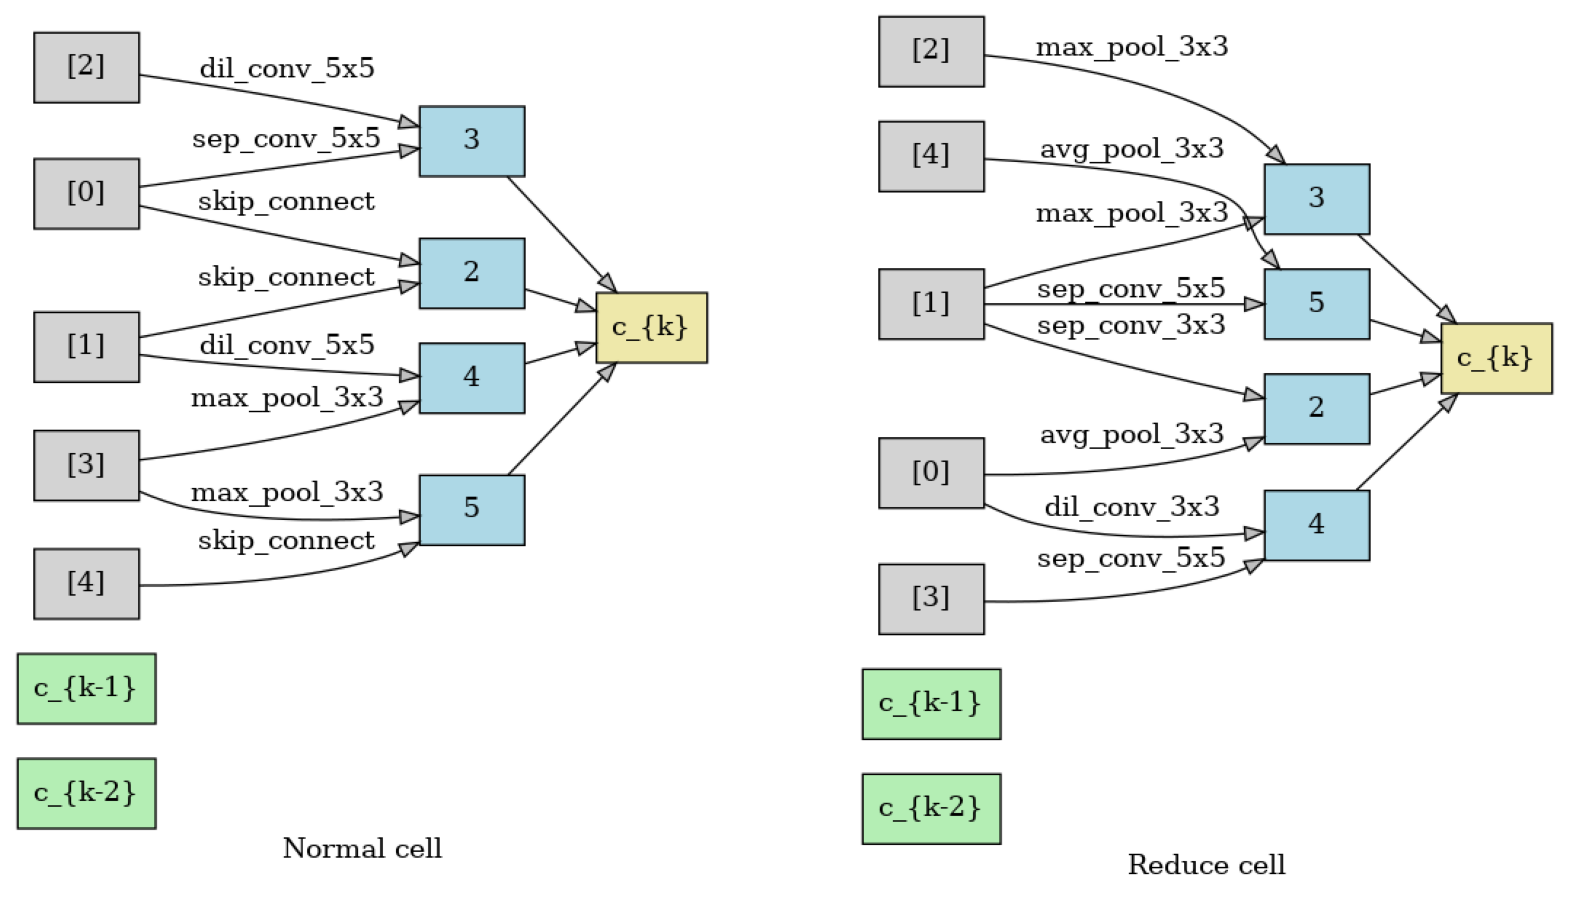

In [11]:
import io
import graphviz
import matplotlib.pyplot as plt
from PIL import Image

def plot_single_cell(arch_dict, cell_name):
    g = graphviz.Digraph(
        node_attr=dict(style='filled', shape='rect', align='center'),
        format='png'
    )
    g.body.extend(['rankdir=LR'])

    g.node('c_{k-2}', fillcolor='darkseagreen2')
    g.node('c_{k-1}', fillcolor='darkseagreen2')
    assert len(arch_dict) % 2 == 0

    for i in range(2, 6):
        g.node(str(i), fillcolor='lightblue')

    for i in range(2, 6):
        for j in range(2):
            op = arch_dict[f'{cell_name}/op_{i}_{j}']
            from_ = arch_dict[f'{cell_name}/input_{i}_{j}']
            if from_ == 0:
                u = 'c_{k-2}'
            elif from_ == 1:
                u = 'c_{k-1}'
            else:
                u = str(from_)
            v = str(i)
            g.edge(u, v, label=op, fillcolor='gray')

    g.node('c_{k}', fillcolor='palegoldenrod')
    for i in range(2, 6):
        g.edge(str(i), 'c_{k}', fillcolor='gray')

    g.attr(label=f'{cell_name.capitalize()} cell')

    image = Image.open(io.BytesIO(g.pipe()))
    return image

def plot_double_cells(arch_dict):
    image1 = plot_single_cell(arch_dict, 'normal')
    image2 = plot_single_cell(arch_dict, 'reduce')
    height_ratio = max(image1.size[1] / image1.size[0], image2.size[1] / image2.size[0])
    _, axs = plt.subplots(1, 2, figsize=(20, 10 * height_ratio))
    axs[0].imshow(image1)
    axs[1].imshow(image2)
    axs[0].axis('off')
    axs[1].axis('off')
    plt.show()

plot_double_cells(exported_arch)

In [18]:
#plot_double_cells({
#    'normal/op_2_0': 'sep_conv_3x3',
#    'normal/input_2_0': 1,
#    'normal/op_2_1': 'sep_conv_3x3',
#    'normal/input_2_1': 0,
#    'normal/op_3_0': 'sep_conv_3x3',
#    'normal/input_3_0': 1,
#    'normal/op_3_1': 'sep_conv_3x3',
#    'normal/input_3_1': 2,
#    'normal/op_4_0': 'sep_conv_3x3',
#    'normal/input_4_0': 1,
#    'normal/op_4_1': 'sep_conv_3x3',
#    'normal/input_4_1': 0,
#    'normal/op_5_0': 'sep_conv_3x3',
#    'normal/input_5_0': 1,
#    'normal/op_5_1': 'max_pool_3x3',
#    'normal/input_5_1': 0,
#    'reduce/op_2_0': 'sep_conv_3x3',
#    'reduce/input_2_0': 0,
#    'reduce/op_2_1': 'sep_conv_3x3',
#    'reduce/input_2_1': 1,
#    'reduce/op_3_0': 'dil_conv_5x5',
#    'reduce/input_3_0': 2,
#    'reduce/op_3_1': 'sep_conv_3x3',
#    'reduce/input_3_1': 0,
#    'reduce/op_4_0': 'dil_conv_5x5',
#    'reduce/input_4_0': 2,
#    'reduce/op_4_1': 'sep_conv_5x5',
#    'reduce/input_4_1': 1,
#    'reduce/op_5_0': 'sep_conv_5x5',
#    'reduce/input_5_0': 4,
#    'reduce/op_5_1': 'dil_conv_5x5',
#    'reduce/input_5_1': 2
#})

## Retrain the searched model

What we have got in the last step, is only a cell structure.
To get a final usable model with trained weights, we need to construct a real model based on this structure,
and then fully train it.

To construct a fixed model based on the architecture dict exported from the experiment,
we can use :func:`nni.nas.space.model_context`. Under the with-context, we will creating a fixed model based on ``exported_arch``,
instead of creating a space.



In [12]:
from nni.nas.space import model_context

with model_context(exported_arch):
    final_model = DartsSpace(width=16, num_cells=8, dataset='cifar')

We then train the model on full CIFAR-10 training dataset, and evaluate it on the original CIFAR-10 validation dataset.



In [13]:
train_loader = DataLoader(train_data, batch_size=96, num_workers=6)  # Use the original training data

The validation data loader can be reused.



In [14]:
valid_loader

We must create a new evaluator here because a different data split is used.
Also, we should avoid the underlying pytorch-lightning implementation of :class:`~nni.nas.evaluator.pytorch.Classification`
evaluator from loading the wrong checkpoint.



In [15]:
max_epochs = 100

evaluator = Classification(
    learning_rate=1e-3,
    weight_decay=1e-4,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,
    max_epochs=max_epochs,
    accelerator='auto',
    export_onnx=False,          # Disable ONNX export for this experiment
    fast_dev_run=fast_dev_run,   # Should be false for fully training
    num_classes = 10
)

evaluator.fit(final_model)

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name      | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train | 0    
1 | metrics   | ModuleDict       | 0      | train | 0    
2 | _model    | DARTS         

Training: |                                                                                                   …

Validation: |                                                                                                 …

[2026-02-23 19:33:26] Intermediate result: 0.09375  (Index 0)


`Trainer.fit` stopped: `max_steps=1` reached.


[2026-02-23 19:33:26] Final result: 0.09375


<div class="alert alert-info"><h4>Note</h4><p>When ``fast_dev_run`` is turned off, we achieve a validation accuracy of 89.69% after training for 100 epochs.</p></div>

## Reproduce results in DARTS paper

After a brief walkthrough of search + retrain process with one-shot strategy,
we then fill the gap between our results (89.69%) and the results in the `DARTS` paper.
This is because we didn't introduce some extra training tricks, including [DropPath](https://arxiv.org/pdf/1605.07648v4.pdf)_,
Auxiliary loss, gradient clipping and augmentations like [Cutout](https://arxiv.org/pdf/1708.04552v2.pdf)_.
They also train the deeper (20 cells) and wider (36 filters) networks for longer time (600 epochs).
Here we reproduce these tricks to get comparable results with DARTS paper.


### Evaluator

To implement these tricks, we first need to rewrite a few parts of evaluator.

Working with one-shot strategies, evaluators need to be implemented in the style of `PyTorch-Lightning <lightning-evaluator>`,
The full tutorial can be found in :doc:`/nas/evaluator`.
Putting it briefly, the core part of writing a new evaluator is to write a new LightningModule.
[LightingModule](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html)_ is a concept in
PyTorch-Lightning, which organizes the model training process into a list of functions, such as,
``training_step``, ``validation_step``, ``configure_optimizers``, etc.
Since we are merely adding a few ingredients to :class:`~nni.nas.evaluator.pytorch.Classification`,
we can simply inherit :class:`~nni.nas.evaluator.pytorch.ClassificationModule`, which is the underlying LightningModule
behind :class:`~nni.nas.evaluator.pytorch.Classification`.
This could look intimidating at first, but most of them are just plug-and-play tricks which you don't need to know details about.



In [ ]:
import torch
from nni.nas.evaluator.pytorch import ClassificationModule

class DartsClassificationModule(ClassificationModule):
    def __init__(
        self,
        learning_rate: float = 0.001,
        weight_decay: float = 0.,
        auxiliary_loss_weight: float = 0.4,
        max_epochs: int = 600,
        num_classes: int = 10
    ):
        self.auxiliary_loss_weight = auxiliary_loss_weight
        # Training length will be used in LR scheduler
        self.max_epochs = max_epochs
        super().__init__(learning_rate=learning_rate, weight_decay=weight_decay, export_onnx=False, num_classes = 10)

    def configure_optimizers(self):
        """Customized optimizer with momentum, as well as a scheduler."""
        optimizer = torch.optim.SGD(
            self.parameters(),
            momentum=0.9,
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, self.max_epochs, eta_min=1e-3)
        }

    def training_step(self, batch, batch_idx):
        """Training step, customized with auxiliary loss."""
        x, y = batch
        if self.auxiliary_loss_weight:
            y_hat, y_aux = self(x)
            loss_main = self.criterion(y_hat, y)
            loss_aux = self.criterion(y_aux, y)
            self.log('train_loss_main', loss_main)
            self.log('train_loss_aux', loss_aux)
            loss = loss_main + self.auxiliary_loss_weight * loss_aux
        else:
            y_hat = self(x)
            loss = self.criterion(y_hat, y)
        self.log('train_loss', loss, prog_bar=True)
        for name, metric in self.metrics.items():
            self.log('train_' + name, metric(y_hat, y), prog_bar=True)
        return loss

    def on_train_epoch_start(self):
        # Set drop path probability before every epoch. This has no effect if drop path is not enabled in model.
        self.model.set_drop_path_prob(self.model.drop_path_prob * self.current_epoch / self.max_epochs)

        # Logging learning rate at the beginning of every epoch
        self.log('lr', self.trainer.optimizers[0].param_groups[0]['lr'])

The full evaluator is written as follows,
which simply wraps everything (except model space and search strategy of course), in a single object.
:class:`~nni.nas.evaluator.pytorch.Lightning` here is a special type of evaluator.
Don't forget to use the train/val data split specialized for search (1:1) here.



In [ ]:
from nni.nas.evaluator.pytorch import Lightning, Trainer

max_epochs = 50

evaluator = Lightning(
    DartsClassificationModule(0.025, 3e-4, 0., max_epochs, num_classes = 10),
    Trainer(
        accelerator="auto",
        max_epochs=max_epochs,
        fast_dev_run=fast_dev_run
    ),
    train_dataloaders=search_train_loader,
    val_dataloaders=search_valid_loader
)

### Strategy

:class:`~nni.nas.strategy.DARTS` strategy is created with gradient clip turned on.
If you are familiar with PyTorch-Lightning, you might aware that gradient clipping can be enabled in Lightning trainer.
However, enabling gradient clip in the trainer above won't work, because the underlying
implementation of :class:`~nni.nas.strategy.DARTS` strategy is based on
[manual optimization](https://pytorch-lightning.readthedocs.io/en/stable/common/optimization.html)_.



In [ ]:
strategy = DartsStrategy(gradient_clip_val=5.)

### Launch experiment

Then we use the newly created evaluator and strategy to launch the experiment again.

<div class="alert alert-danger"><h4>Warning</h4><p>``model_space`` has to be re-instantiated because a known limitation,
   i.e., one model space instance can't be reused across multiple experiments.</p></div>



In [ ]:
model_space = DartsSpace(width=16, num_cells=8, dataset='cifar')

experiment = NasExperiment(model_space, evaluator, strategy)
experiment.run()

exported_arch = experiment.export_top_models(formatter='dict')[0]

exported_arch

We get the following architecture when ``fast_dev_run`` is set to False. It takes around 8 hours on a P100 GPU.



In [ ]:
plot_double_cells({
    'normal/op_2_0': 'sep_conv_3x3',
    'normal/input_2_0': 0,
    'normal/op_2_1': 'sep_conv_3x3',
    'normal/input_2_1': 1,
    'normal/op_3_0': 'sep_conv_3x3',
    'normal/input_3_0': 1,
    'normal/op_3_1': 'skip_connect',
    'normal/input_3_1': 0,
    'normal/op_4_0': 'sep_conv_3x3',
    'normal/input_4_0': 0,
    'normal/op_4_1': 'max_pool_3x3',
    'normal/input_4_1': 1,
    'normal/op_5_0': 'sep_conv_3x3',
    'normal/input_5_0': 0,
    'normal/op_5_1': 'sep_conv_3x3',
    'normal/input_5_1': 1,
    'reduce/op_2_0': 'max_pool_3x3',
    'reduce/input_2_0': 0,
    'reduce/op_2_1': 'sep_conv_5x5',
    'reduce/input_2_1': 1,
    'reduce/op_3_0': 'dil_conv_5x5',
    'reduce/input_3_0': 2,
    'reduce/op_3_1': 'max_pool_3x3',
    'reduce/input_3_1': 0,
    'reduce/op_4_0': 'max_pool_3x3',
    'reduce/input_4_0': 0,
    'reduce/op_4_1': 'sep_conv_3x3',
    'reduce/input_4_1': 2,
    'reduce/op_5_0': 'max_pool_3x3',
    'reduce/input_5_0': 0,
    'reduce/op_5_1': 'skip_connect',
    'reduce/input_5_1': 2
})

### Retrain

When retraining,
we extend the original dataloader to introduce another trick called [Cutout](https://arxiv.org/pdf/1708.04552v2.pdf)_.
Cutout is a data augmentation technique that randomly masks out rectangular regions in images.
In CIFAR-10, the typical masked size is 16x16 (the image sizes are 32x32 in the dataset).



In [ ]:
def cutout_transform(img, length: int = 16):
    h, w = img.size(1), img.size(2)
    mask = np.ones((h, w), np.float32)
    y = np.random.randint(h)
    x = np.random.randint(w)

    y1 = np.clip(y - length // 2, 0, h)
    y2 = np.clip(y + length // 2, 0, h)
    x1 = np.clip(x - length // 2, 0, w)
    x2 = np.clip(x + length // 2, 0, w)

    mask[y1: y2, x1: x2] = 0.
    mask = torch.from_numpy(mask)
    mask = mask.expand_as(img)
    img *= mask
    return img

transform_with_cutout = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
    cutout_transform,
])

The train dataloader needs to be reinstantiated with the new transform.
The validation dataloader is not affected, and thus can be reused.



In [ ]:
train_data_cutout = nni.trace(CIFAR10)(root='./data', train=True, download=True, transform=transform_with_cutout)
train_loader_cutout = DataLoader(train_data_cutout, batch_size=96)

We then create the final model based on the new exported architecture.
This time, auxiliary loss and drop path probability is enabled.

Following the same procedure as paper, we also increase the number of filters to 36, and number of cells to 20,
so as to reasonably increase the model size and boost the performance.



In [ ]:
with model_context(exported_arch):
    final_model = DartsSpace(width=36, num_cells=20, dataset='cifar', auxiliary_loss=True, drop_path_prob=0.2)

We create a new evaluator for the retraining process, where the gradient clipping is put into the keyword arguments of trainer.



In [ ]:
max_epochs = 600

evaluator = Lightning(
    DartsClassificationModule(0.025, 3e-4, 0.4, max_epochs),
    trainer=Trainer(
        accelerator="auto",
        gradient_clip_val=5.,
        max_epochs=max_epochs,
        fast_dev_run=fast_dev_run
    ),
    train_dataloaders=train_loader_cutout,
    val_dataloaders=valid_loader,
)

evaluator.fit(final_model)

When ``fast_dev_run`` is turned off, after retraining, the architecture yields a top-1 accuracy of 97.12%.
If we take the best snapshot throughout the retrain process,
there is a chance that the top-1 accuracy will be 97.28%.

<img src="https://nni.readthedocs.io/en/stable/_images/darts_val_acc.png">

In the figure, the orange line is the validation accuracy curve after training for 600 epochs,
while the red line corresponding the previous version in this tutorial before adding all the training tricks and
only trains for 100 epochs.

The results outperforms "DARTS (first order) + cutout" in `DARTS`_ paper, which is only 97.00±0.14%.
It's even comparable with "DARTS (second order) + cutout" in the paper (97.24±0.09%),
though we didn't implement the second order version.
The implementation of second order DARTS is in our future plan, and we also welcome your contribution.

